# Avaliação 08 - Implementação de Filtros Digitais

---

### Projeto 2: Butterworth por Transformação Bilinear

ENGC63 - 2021.2

João Carneiro e Osmar Oliveira

# Trabalho de Processamento Digital de Sinais (ENGC63)


- Projete, a partir de um filtro passa-baixas Butterworth de sexta ordem, um filtro discreto passa-baixas com frequência de corte (-3dB) igual ω c = 2π/3, usando o método da invariância da resposta
impulsiva (**Projeto1**) ou usando o método de transformação bilinear (**Projeto2**) 

- Faça a implementação sob forma direta e sob forma em cascata. 

- Represente os coeficientes em ponto flutuante (ex.: 0, 00423578 = 0, 423578 × 10 − 2 ) e vá diminuindo o número de casas decimais após a vı́rgula nas formas direta e em cascata para verificar a sensibilidade à quantização de parâmetros. 

- Trace a curva do módulo da resposta em freqência em dB para os casos de precisão infinita e precisão finita. 
Em seguida, para a representação em forma direta, refaça os filtros com as 3 transformações em frequência a seguir (Z − 1 = −z − 1 ; Z − 1 = z − 2 e Z − 1 = −z − 2 ) e trace a curva do módulo em dB da resposta em frequência resultante. 

- Use os seus filtros para processar um sinal de áudio de sua preferência, ouça os resultados e os avalie perceptualmente. Avalie, também, o espectro em função do tempo, do sinal de entrada e de saída utilizando um espectrograma.


## Imports

In [1]:
import math
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from scipy.io.wavfile import read, write
from IPython.display import display, Math, Audio

## Funções Auxiliares

In [2]:
# Imprime float em notação científica
def print_scientific(number):
    exp = np.floor(np.log10(np.abs(number))).astype(int)
    num = number * 10.0**(-exp - 1)
    display(Math(r"{0} \times 10^{{{1}}}".format(num, exp+1)))

# Reduz precisão da mantissa de um float
def reduce_precision(num, precision):
    exp = np.floor(np.log10(np.abs(num))).astype(int)
    num = round(num, exp+precision)
    return num

## Filtro Discreto Passa-Baixas

Transformação bilinear de um filtro Butterworth

### Filtro Butterworth

In [3]:
ordem = 6       # Ordem do Butterworth
fs = 48000      # Freq de amostragem para audio de 24kHz
wc = 2*np.pi/3  # Freq de corte
Wc = wc*fs      # Freq angular

# Cria filtro Butterworth:
filts = signal.lti(*signal.butter(ordem, Wc, btype='lowpass', analog=True, output='ba'))


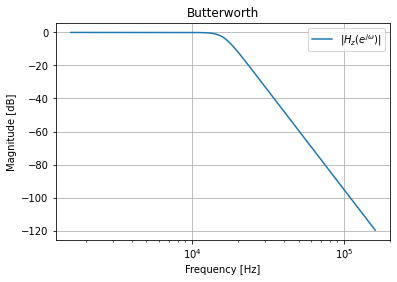

In [4]:
wz, hz = signal.freqs(filts.num, filts.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title('Butterworth')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

### Transformação Bilinear

In [5]:
# Converte Butterworth para filtro discreto por Transformação Linear:
filtz = signal.dlti(*signal.bilinear(filts.num, filts.den, fs=fs))

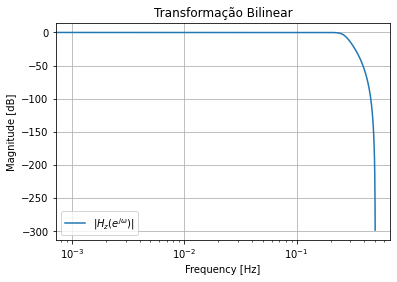

In [6]:
wz, hz = signal.freqz(filtz.num, filtz.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## Função para Forma Direta I

In [7]:
# Encontra saída pela Forma Direta I
def direct_i(input_x, filtz):
    x = input_x.copy()
    input_size = len(x)

    b = filtz.num.copy()
    a = filtz.den.copy()

    M = len(b) - 1
    N = len(a) - 1

    y = np.zeros(input_size)

    # Função para retornar 0 em caso de índice inválido
    def get_value(array, index):
        try:
            return array[index]
        except:
            return 0

    # Percorre por toda entrada
    for n in range(input_size):
        # Somatórios resultantes da Forma Direta I
        for i in range(M+1):
            y[n] += b[i] * get_value(x, n - 1)
        for j in range(1, N+1):
            y[n] -= a[j] * get_value(y, n - j)
    
    return y

## Função para Forma em Cascata

In [8]:
# Encontra saída pela Forma em Cascata
def cascade(input_x, filtz):
    x = input_x.copy()
    b = filtz.num.copy()
    a = filtz.den.copy()

    # Converte TF para SOS (seções de 2a ordem)
    sos = signal.tf2sos(b, a)

    # Filtra entrada pela sequência em cascata das funções
    y = signal.sosfilt(sos, x)

    return y


## Cria filtros com menos casas decimais

In [9]:
# Calcula resposta em frequência
wz1, hz1 = signal.freqz(filtz.num, filtz.den)

filtz_5prec = signal.dlti(filtz.num, filtz.den)

for i, val in enumerate(filtz_5prec.num):
    filtz_5prec.num[i] = reduce_precision(val, 5)
for i, val in enumerate(filtz_5prec.den):
    filtz_5prec.den[i] = reduce_precision(val, 5)

wz2, hz2 = signal.freqz(filtz_5prec.num, filtz_5prec.den)

filtz_3prec = signal.dlti(filtz.num, filtz.den)

for i, val in enumerate(filtz_3prec.num):
    filtz_3prec.num[i] = reduce_precision(val, 3)
for i, val in enumerate(filtz_3prec.den):
    filtz_3prec.den[i] = reduce_precision(val, 3)

wz3, hz3 = signal.freqz(filtz_3prec.num, filtz_3prec.den)


# Transformação $Z^{-1} = -z^{-1}$

In [10]:
def first_transf_tf(b, a):
    b1 = b.copy()
    a1 = a.copy()
    for idx, val in enumerate(b1):
        if idx % 2 == b1.shape[0] % 2:
            b1[idx] = -val
    for idx, val in enumerate(a1):
        if idx % 2 == a1.shape[0] % 2:
            a1[idx] = -val
    return b1, a1


filtz_ft = signal.dlti(*first_transf_tf(filtz.num, filtz.den))

# Transformação $Z^{-1} = z^{-2}$

In [11]:
def second_transf_tf(b, a):
    newList = []
    for idx, val in enumerate(b):
        newList.append(val)
        newList.append(0)
    b1 = np.array(newList[:-1])
    newList = []
    for idx, val in enumerate(a):
        newList.append(val)
        newList.append(0)
    a1 = np.array(newList[:-1])

    return b1, a1


filtz_st =  signal.dlti(*second_transf_tf(filtz.num, filtz.den))

# Transformação $Z^{-1} = -z^{-2}$

In [12]:
def third_transf_tf(b, a):
    b_1, a_1 = first_transf_tf(b, a)
    b_2, a_2 = second_transf_tf(b_1, a_1)
    return b_2, a_2

filtz_tt = signal.dlti(*third_transf_tf(filtz.num, filtz.den))

## Carrega áudio de entrada

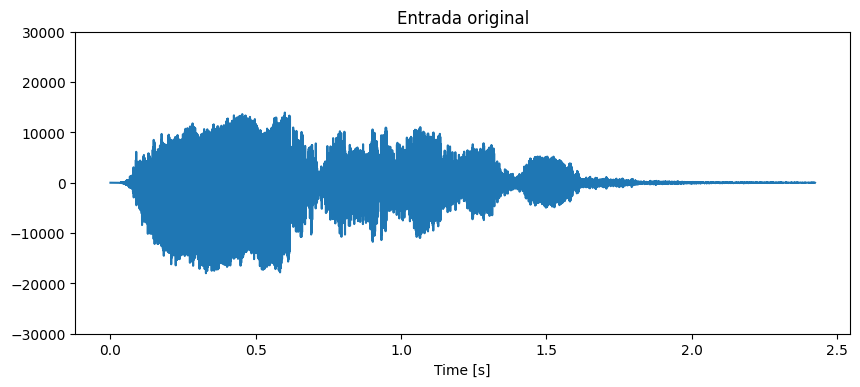

In [13]:
(freq, x) = read('goofy-yell.wav')
t = np.linspace(0, x.shape[0]/freq, x.shape[0])

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, x)
plt.ylim(-30000, 30000)
ax_sound = plt.axis()
plt.title("Entrada original")
plt.xlabel("Time [s]")
Audio('goofy-yell.wav')

## Filtragem

### Direto com precisão infinita

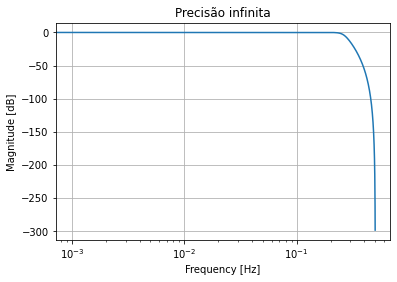

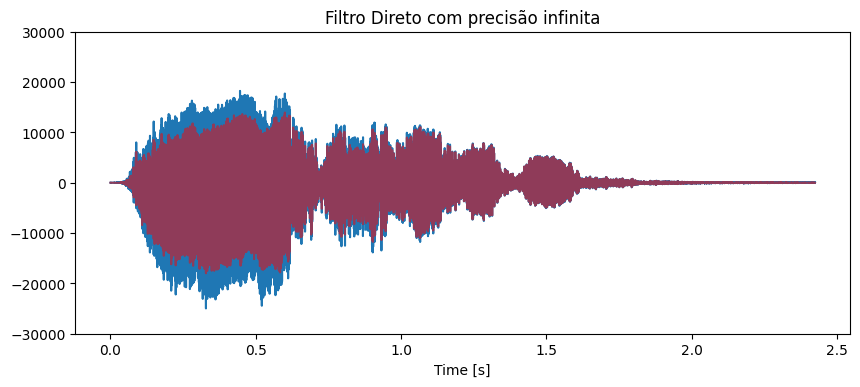

Erro médio:


<IPython.core.display.Math object>

In [14]:
direct_infi = direct_i(x, filtz)

plt.semilogx(wz1*1/(2*np.pi), 20*np.log10(np.abs(hz1).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
ax = plt.axis()
plt.title('Precisão infinita')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, direct_infi)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Direto com precisão infinita")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(direct_infi - x))

Audio(direct_infi, rate=freq)

### Direto com precisão de 5 casas decimais

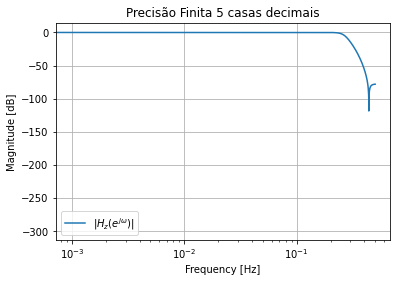

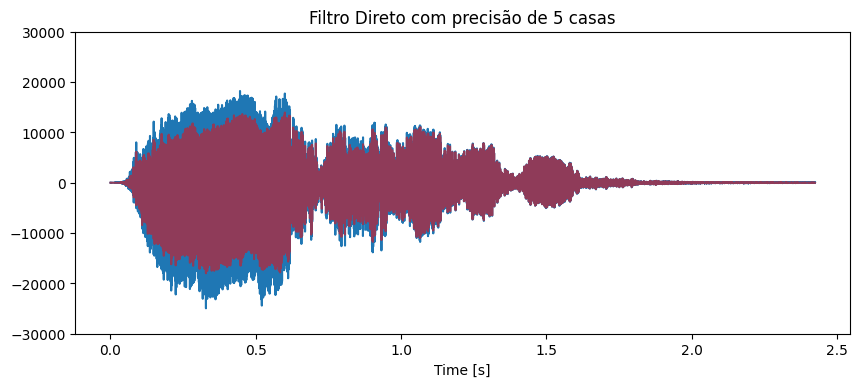

Erro médio:


<IPython.core.display.Math object>

In [15]:
direct_5 = direct_i(x, filtz_5prec)

plt.figure()
plt.semilogx(wz2*1/(2*np.pi), 20*np.log10(np.abs(hz2).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.legend()
plt.title('Precisão Finita 5 casas decimais')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, direct_5)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Direto com precisão de 5 casas")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(direct_5 - x))

Audio(direct_5, rate=freq)

### Direto com precisão de 3 casas decimais

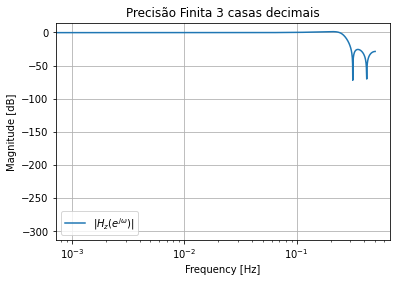

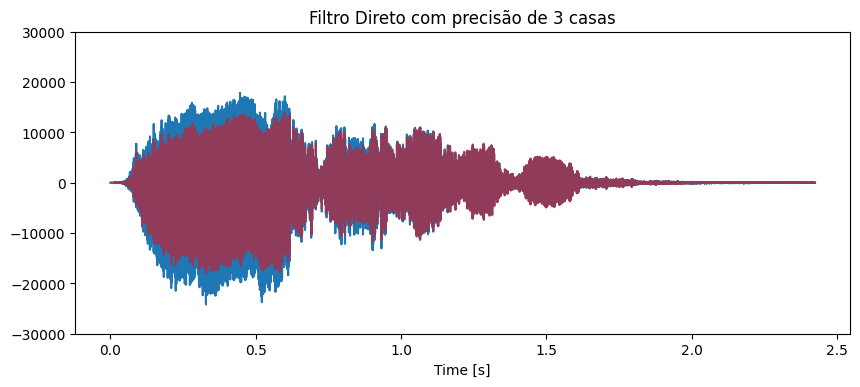

Erro médio:


<IPython.core.display.Math object>

In [16]:
direct_3 = direct_i(x, filtz_3prec)

plt.figure()
plt.semilogx(wz3*1/(2*np.pi), 20*np.log10(np.abs(hz3).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.legend()
plt.title('Precisão Finita 3 casas decimais')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, direct_3)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Direto com precisão de 3 casas")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(direct_3 - x))

Audio(direct_3, rate=freq)

### Cascata com precisão infinita

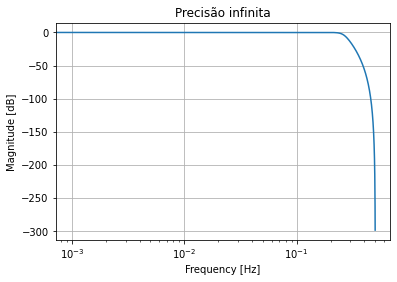

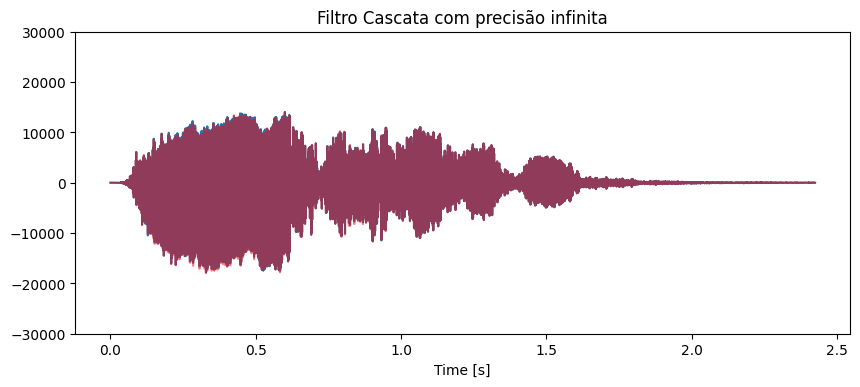

Erro médio:


<IPython.core.display.Math object>

In [17]:
cascade_infi = cascade(x, filtz)

plt.semilogx(wz1*1/(2*np.pi), 20*np.log10(np.abs(hz1).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
ax = plt.axis()
plt.title('Precisão infinita')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, cascade_infi)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Cascata com precisão infinita")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(cascade_infi - x))

Audio(cascade_infi, rate=freq)

### Cascata com precisão de 5 casas decimais

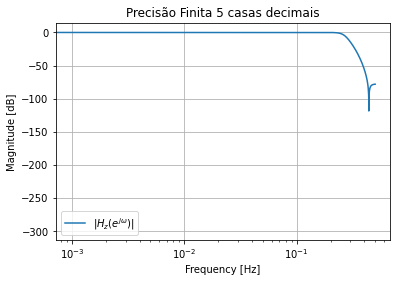

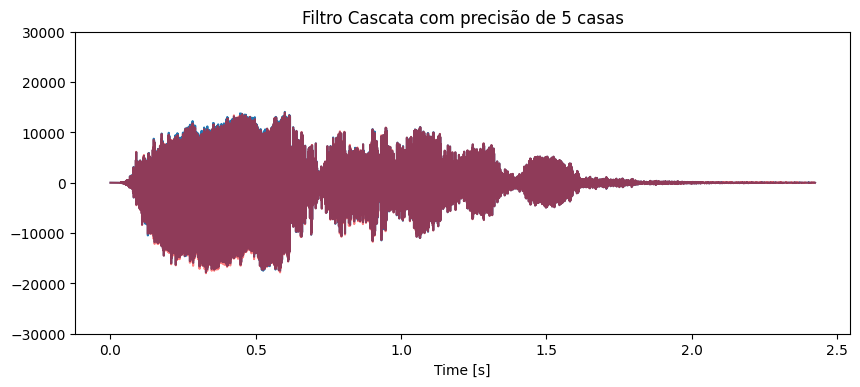

Erro médio:


<IPython.core.display.Math object>

In [18]:
cascade_5 = cascade(x, filtz_5prec)

plt.figure()
plt.semilogx(wz2*1/(2*np.pi), 20*np.log10(np.abs(hz2).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.legend()
plt.title('Precisão Finita 5 casas decimais')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, cascade_5)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Cascata com precisão de 5 casas")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(cascade_5 - x))

Audio(cascade_5, rate=freq)

### Cascata com precisão de 3 casas decimais

TransferFunctionDiscrete(
array([0.  , 0.2 , 0.51, 0.68, 0.51, 0.2 , 0.  ]),
array([1.  , 0.17, 0.79, 0.1 , 0.12, 0.  , 0.  ]),
dt: True
)


/home/jcarneiro/.local/lib/python3.8/site-packages/scipy/signal/filter_design.py:1631: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


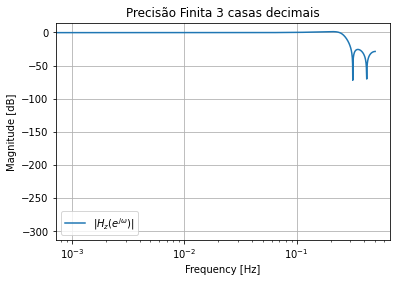

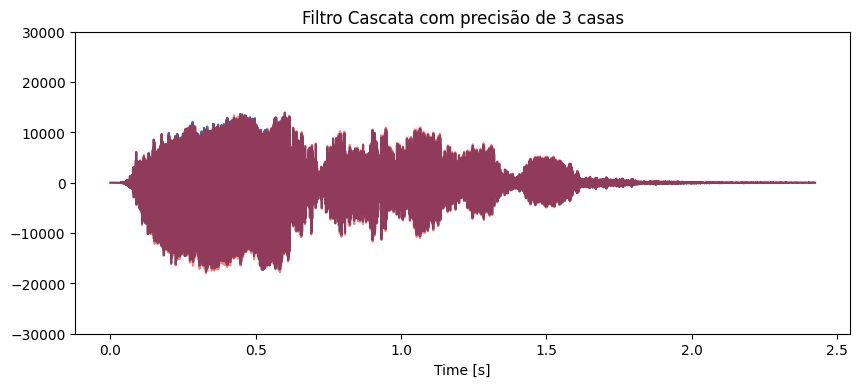

Erro médio:


<IPython.core.display.Math object>

In [19]:
cascade_3 = cascade(x, filtz_3prec)
print(filtz_3prec)

plt.figure()
plt.semilogx(wz3*1/(2*np.pi), 20*np.log10(np.abs(hz3).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.legend()
plt.title('Precisão Finita 3 casas decimais')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, cascade_3)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Cascata com precisão de 3 casas")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(cascade_3 - x))

Audio(cascade_3, rate=freq)

### Direto com Transformação $Z^{-1} = -z^{-1}$

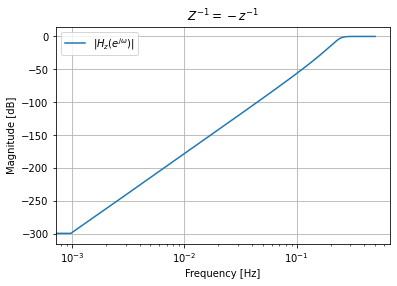

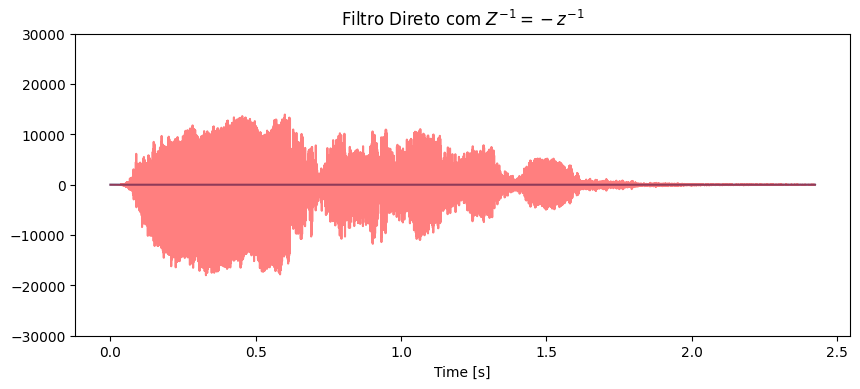

Erro médio:


<IPython.core.display.Math object>

In [20]:
trans1 = direct_i(x, filtz_ft)

wz, hz = signal.freqz(filtz_ft.num, filtz_ft.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title(r'$ Z^{-1} = -z^{-1} $')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, trans1)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Direto com $Z^{-1} = -z^{-1}$")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(trans1 - x))

Audio(trans1, rate=freq)

### Direto com Transformação $Z^{-1} = z^{-2}$

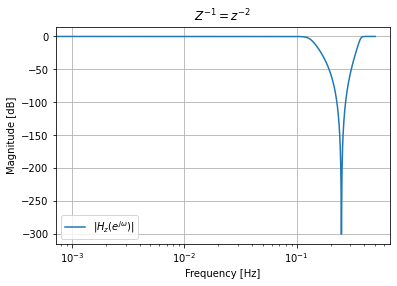

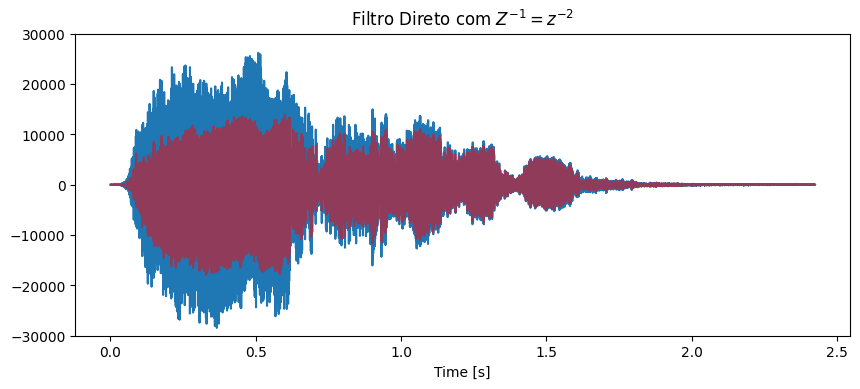

Erro médio:


<IPython.core.display.Math object>

In [21]:
trans2 = direct_i(x, filtz_st)

wz, hz = signal.freqz(filtz_st.num, filtz_st.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title(r'$Z^{-1} = z^{-2}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, trans2)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Direto com $Z^{-1} = z^{-2}$")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(trans2 - x))

Audio(trans2, rate=freq)

### Direto com Transformação $Z^{-1} = -z^{-2}$

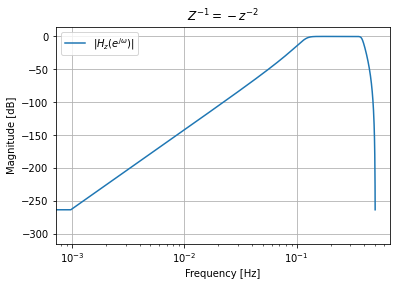

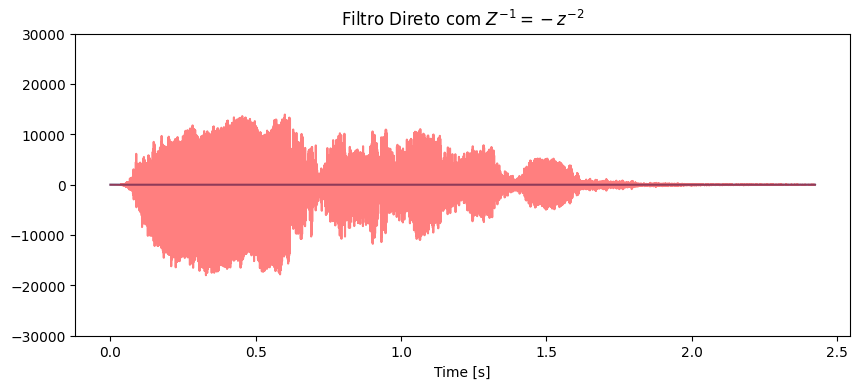

Erro médio:


<IPython.core.display.Math object>

In [22]:
trans3 = direct_i(x, filtz_tt)

wz, hz = signal.freqz(filtz_tt.num, filtz_tt.den)

plt.semilogx(wz*1/(2*np.pi), 20*np.log10(np.abs(hz).clip(1e-15)),label=r'$|H_z(e^{j \omega})|$')
plt.legend()
plt.title(r'$Z^{-1} = -z^{-2}$')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, trans3)
plt.plot(t, x, "red", alpha=0.5)
plt.axis((ax_sound))
plt.title("Filtro Direto com $Z^{-1} = -z^{-2}$")
plt.xlabel("Time [s]")
plt.show()
 
print("Erro médio:")
print_scientific(np.mean(trans3 - x))

Audio(trans3, rate=freq)